[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Anteemony/sktime-storesales-forecasting/blob/main/notebooks/Store_Sales_Forecasting_with_Sktime.ipynb)

# 🏪Store Sales - Time Series Forecasting *using Sktime*

**Project Description**

Using the Sktime framework for our time-series forecasting, how can we predict grocery sales? The aim is to predict the sales for thousands of product families sold at Favorita stores located in Eucador.

**Data**

The data is downloaded from the Kaggle Competition [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

A codeblock has been provided to download this data directly from kaggle programmatically.

**Evaluation**

The evaluation metric is the Root Mean Squared Log Error or RMSLE between the actual and predicted sales.

## Download Kaggle Data

Uncomment the below codeblock to download the datasets from kaggle programmatically. You would need to get your configure input your Kaggle API key and username. Find your API Key from your Kaggle settings [here](https://www.kaggle.com/settings).

In [1]:
# from google.colab import userdata
# import os

# os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
# os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# !kaggle competitions download -c store-sales-time-series-forecasting

# ! unzip "store-sales-time-series-forecasting.zip" -d data

In [2]:
# ensure required libraries are installed
!pip -q install sktime pmdarima seaborn

# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EDA / modelling
import sktime

# ignore warnings for clean cell output
from warnings import simplefilter
simplefilter('ignore')


[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Datasets

The datasets provided by Kaggle include: 

* **train.csv**
* **test.csv**
* **transactions.csv**
* **stores.csv**
* **holiday_events.csv**
* **oil.csv**


**Additional Notes**

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

## Features:

* *date*: Date of entry
* *store_nbr*: Store Number
* *family*: Product Family
* *onpromotion*: Items in a product family being promoted at a store at a given date.
* *sales (Target variable)*: Total sales for a product family at a particular store at a given date.
* *cluster*: Grouping of similar stores
* *type*: Type of Store
* *city*: City
* *state*: State the store is located in
* *holiday_type & locale* : If it was a holiday and type of holiday
* *transactions*: Number of transactions

In [77]:
# Dtype for loading datasets
dtype = {
    'store_nbr': 'int64',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',

    'city': 'category',
    'state': 'category',
    'type': 'category',
    'cluster': 'category',

    'dcoilwtico': 'float32',

    'type': 'category',
    'locale': 'category',
    'locale_name': 'category',
    'description': 'string',
    'transferred': 'bool',

    'transactions': 'int64'
}


# Part 1: Exploratory Data Analysis (EDA)

The data will be explored by datasets, transformations if any will be applied after understanding the imported information.

## 1. `store_sales` 

 Dataset: **train.csv**
 
The training data, comprising time series of features. Columns include:

- *store_nbr*
- *family*
- *onpromotion*
- *sales (target)*

In [78]:
store_sales = pd.read_csv(
    './data/train.csv',
    dtype=dtype,
    parse_dates=['date']
)

In [79]:
# dataset overview
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       category      
 4   sales        float32       
 5   onpromotion  uint64        
dtypes: category(1), datetime64[ns](1), float32(1), int64(2), uint64(1)
memory usage: 105.9 MB


In [80]:
# Check for missing values
store_sales.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [81]:
# What's the time range?
store_sales["date"]

0         2013-01-01
1         2013-01-01
2         2013-01-01
3         2013-01-01
4         2013-01-01
             ...    
3000883   2017-08-15
3000884   2017-08-15
3000885   2017-08-15
3000886   2017-08-15
3000887   2017-08-15
Name: date, Length: 3000888, dtype: datetime64[ns]

In [96]:
# How many stores?
store_sales["store_nbr"].nunique(), store_sales["store_nbr"].unique()

(54,
 array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
         7,  8,  9], dtype=int64))

In [83]:
# How many family classes?
store_sales["family"].nunique(), store_sales["family"].unique()

(33,
 ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', ..., 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
 Length: 33
 Categories (33, object): ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'])

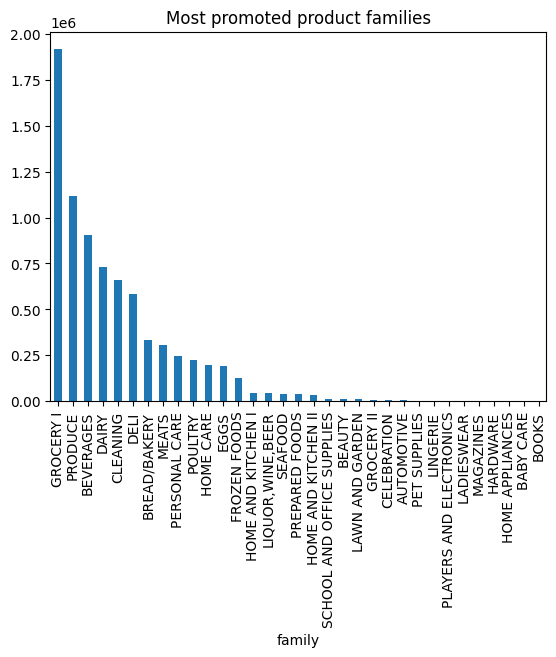

In [103]:
# Most promoted product family?
promoted_families = store_sales.groupby("family")["onpromotion"].sum().sort_values(ascending=False)
promoted_families.plot(kind="bar", title="Most promoted product families");

<Axes: title={'center': 'Product Family Sales'}, xlabel='family'>

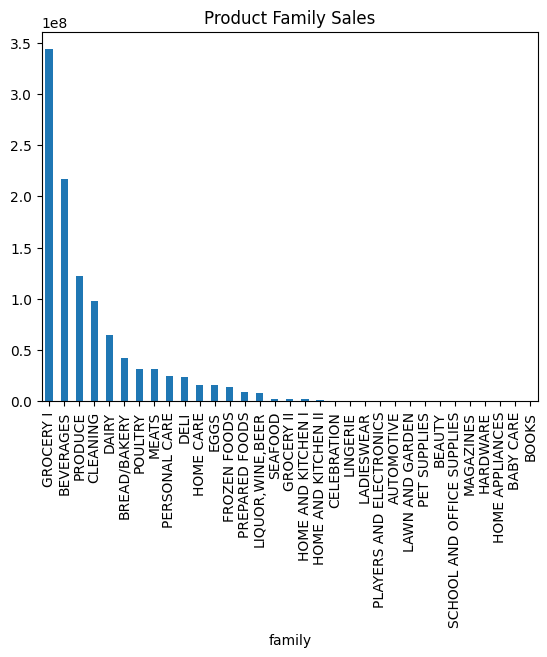

In [104]:
# Product families making the most sales
family_sales = store_sales.groupby("family")["sales"].sum().sort_values(ascending=False)
family_sales.plot(kind="bar", title="Product Family Sales")

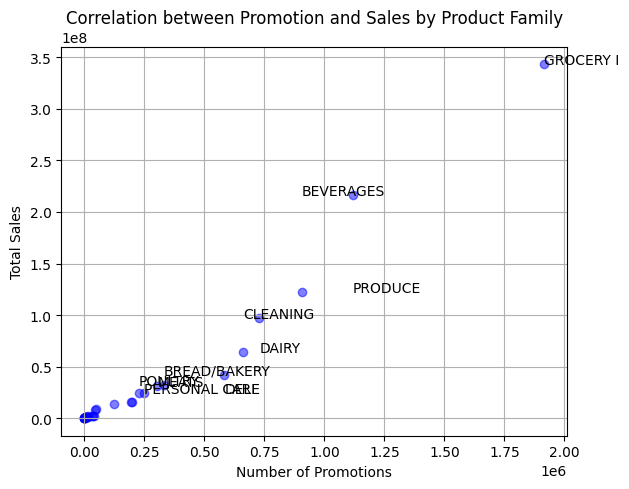

In [122]:
# Create a scatter plot to check correlation
plt.figure(figsize=(6,5))
plt.scatter(promoted_families, family_sales, color='b', alpha=0.5)
plt.title('Correlation between Promotion and Sales by Product Family')
plt.xlabel('Number of Promotions')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()

# annotate top 10 promotions
for family_name in promoted_families[:10].index:
    plt.annotate(family_name, (promoted_families[family_name], family_sales[family_name]))

plt.show()

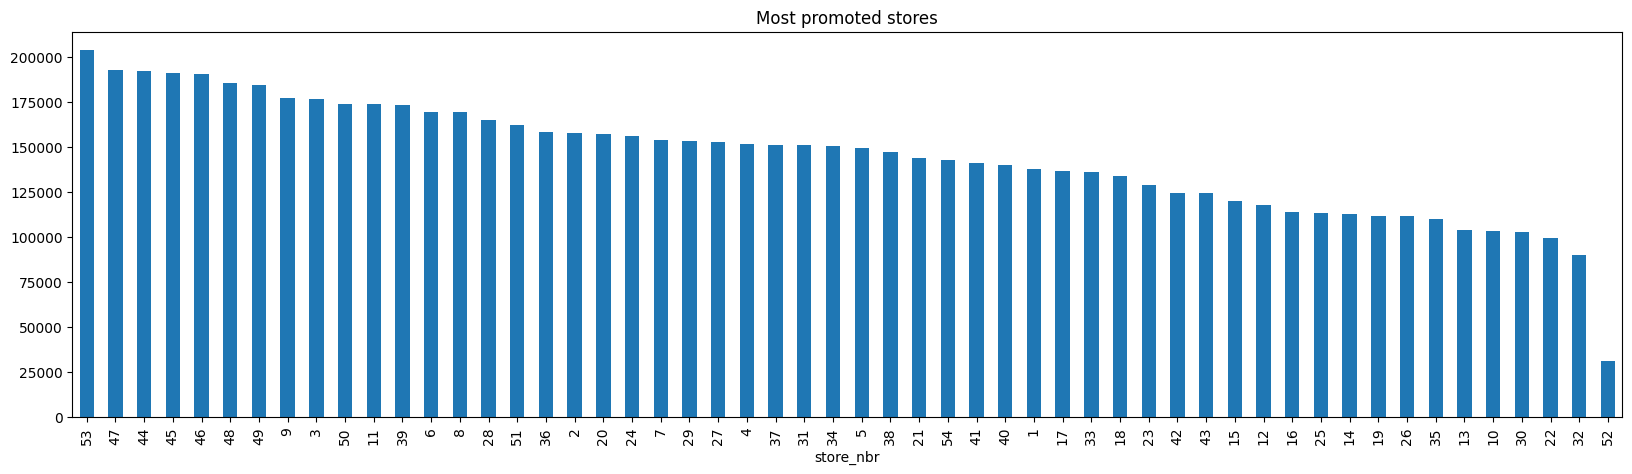

In [123]:
# Most promoted stores
promoted_stores = store_sales.groupby("store_nbr")["onpromotion"].sum().sort_values(ascending=False)
promoted_stores.plot(kind="bar", figsize=(20,5), title="Most promoted stores");

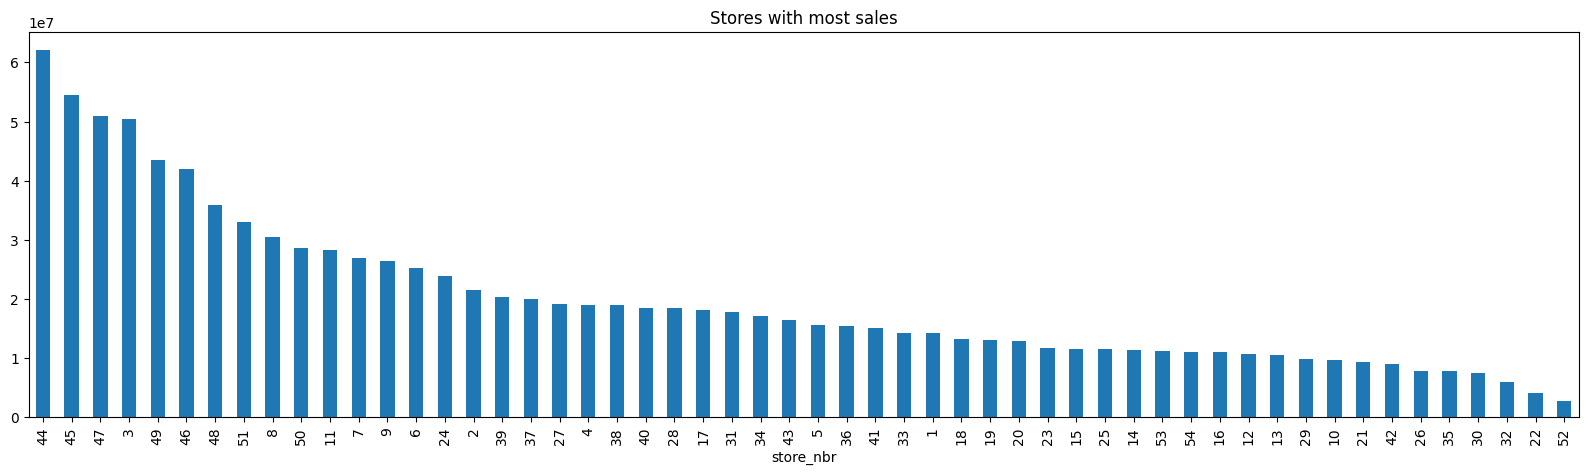

In [124]:
# Stores with most sales
sales_by_store = store_sales.groupby("store_nbr")["sales"].sum().sort_values(ascending=False)
sales_by_store.plot(kind="bar", figsize=(20,5), title="Stores with most sales");

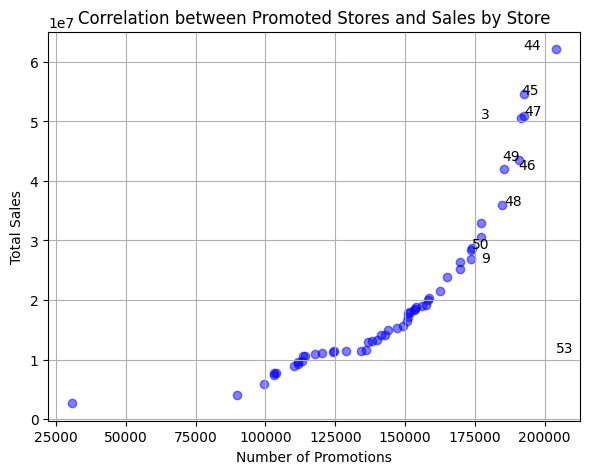

In [130]:
# Create a scatter plot to check correlation
plt.figure(figsize=(6,5))
plt.scatter(promoted_stores, sales_by_store, color='b', alpha=0.5)
plt.title('Correlation between Promoted Stores and Sales by Store')
plt.xlabel('Number of Promotions')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()

# annotate top 10 promotions
for family_name in promoted_stores[:10].index:
    plt.annotate(family_name, (promoted_stores[family_name], sales_by_store[family_name]))

plt.show()

The dataset is a time series of the product family sales for each of the favorita stores at every given day.

In [92]:
# rearrange dataset temporarily to match the description
storesales_reindexed = store_sales.groupby(['date', 'store_nbr', 'family']).mean()
storesales_reindexed[:40]

id  sales  onpromotion
date       store_nbr family                                               
2013-01-01 1         AUTOMOTIVE                    0.0    0.0          0.0
                     BABY CARE                     1.0    0.0          0.0
                     BEAUTY                        2.0    0.0          0.0
                     BEVERAGES                     3.0    0.0          0.0
                     BOOKS                         4.0    0.0          0.0
                     BREAD/BAKERY                  5.0    0.0          0.0
                     CELEBRATION                   6.0    0.0          0.0
                     CLEANING                      7.0    0.0          0.0
                     DAIRY                         8.0    0.0          0.0
                     DELI                          9.0    0.0          0.0
                     EGGS                         10.0    0.0          0.0
                     FROZEN FOODS                 11.0    0.0          0.0
                     GROCERY I                    12.0    0.0          0.0
                     GROCERY II                   13.0    0.0          0.0
                     HARDWARE                     14.0    0.0          0.0
                     HOME AND KITCHEN I           15.0    0.0          0.0
                     HOME AND KITCHEN II          16.0    0.0          0.0
                     HOME APPLIANCES              17.0    0.0          0.0
                     HOME CARE                    18.0    0.0          0.0
                     LADIESWEAR                   19.0    0.0          0.0
                     LAWN AND GARDEN              20.0    0.0          0.0
                     LINGERIE                     21.0    0.0          0.0
                     LIQUOR,WINE,BEER             22.0    0.0          0.0
                     MAGAZINES                    23.0    0.0          0.0
                     MEATS                        24.0    0.0          0.0
                     PERSONAL CARE                25.0    0.0          0.0
                     PET SUPPLIES                 26.0    0.0          0.0
                     PLAYERS AND ELECTRONICS      27.0    0.0          0.0
                     POULTRY                      28.0    0.0          0.0
                     PREPARED FOODS               29.0    0.0          0.0
                     PRODUCE                      30.0    0.0          0.0
                     SCHOOL AND OFFICE SUPPLIES   31.0    0.0          0.0
                     SEAFOOD                      32.0    0.0          0.0
           2         AUTOMOTIVE                  363.0    0.0          0.0
                     BABY CARE                   364.0    0.0          0.0
                     BEAUTY                      365.0    0.0          0.0
                     BEVERAGES                   366.0    0.0          0.0
                     BOOKS                       367.0    0.0          0.0
                     BREAD/BAKERY                368.0    0.0          0.0
                     CELEBRATION                 369.0    0.0          0.0

Analyses:

The dataset is a time series of the product family sales for each of the favorita stores at every given day.

It covers four years of observations spanning from the 1st of January 2013 to the 15th of August 2017.

There are 54 different stores which all have the same product families.

There is a positive correlation between the Promoted product families and families making the most sales. There is also a positive correlation between the Promoted stores and stores making the most sales. These highlights the promotions has a significant on Favorita's sales.

### Feature Enrichment

In [16]:
# dates informatino
store_sales[:1].date.dt.year

0    2013
Name: date, dtype: int32

In [11]:
# make a copy of store_sales
df_tmp = store_sales.copy()

In [18]:
df_tmp["saleYear"] = df_tmp.date.dt.year
df_tmp["saleMonth"] = df_tmp.date.dt.month
df_tmp["saleDay"] = df_tmp.date.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.date.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.date.dt.dayofyear

In [22]:
df_tmp.head()

,id,date,store_nbr,family,sales,onpromotion,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,1


### Limited Transaction Features

Base assumptions and limitations:

1. The model assumes a linear relationship between sales and transactions, that is, it assumes that a product family's percentage contribution to total sales is the same as its percentage contribution to total transactions.

2. It's a simplified model that provides an estimate for the distribution of transactions across different product families based on their proportion of total sales. It does not take into account possible variations in product price or buying patterns between the different product families.

3. This model should be validated and refined with more granular data (where available), statistical analysis or domain knowledge.


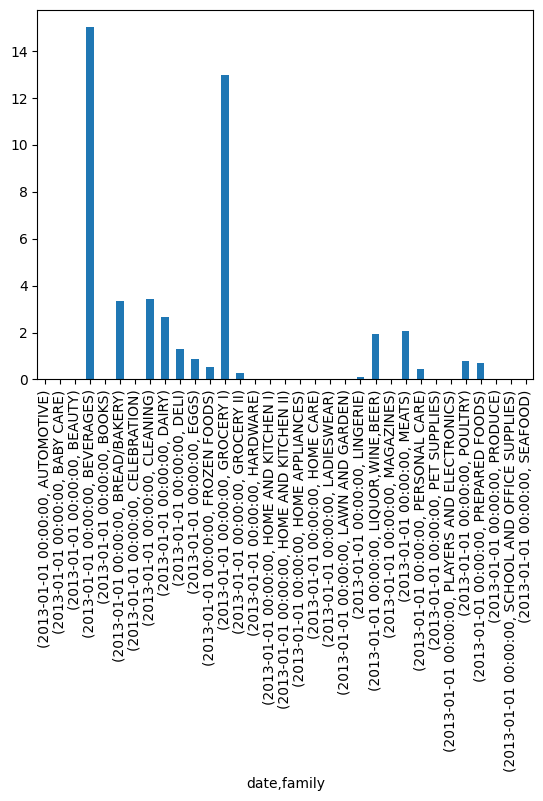

In [118]:
ft = day_1.groupby(['date', 'family'])["sales"].mean()
ft.plot(kind="bar");

In [151]:
day_1[day_1["sales"]!=0]

,id,date,store_nbr,family,sales,onpromotion
563,563,2013-01-01,25,BEAUTY,2.000000,0
564,564,2013-01-01,25,BEVERAGES,810.000000,0
566,566,2013-01-01,25,BREAD/BAKERY,180.589005,0
568,568,2013-01-01,25,CLEANING,186.000000,0
569,569,2013-01-01,25,DAIRY,143.000000,0
570,570,2013-01-01,25,DELI,71.089996,0
571,571,2013-01-01,25,EGGS,46.000000,0
572,572,2013-01-01,25,FROZEN FOODS,29.654999,0
573,573,2013-01-01,25,GROCERY I,700.000000,0
574,574,2013-01-01,25,GROCERY II,15.000000,0


In [171]:
# Pivot the data for easier plotting (date as index, family as columns)
d1 = day_1[day_1['sales']!=0]
d1 = d1.pivot(index='date', columns='family', values='sales')
d1

family,BEAUTY,BEVERAGES,BREAD/BAKERY,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MEATS,PERSONAL CARE,POULTRY,PREPARED FOODS
date,,,,,,,,,,,,,,,,,
2013-01-01,2.0,810.0,180.589005,186.0,143.0,71.089996,46.0,29.654999,700.0,15.0,2.0,5.0,105.0,110.801003,25.0,42.637001,37.847


In [159]:
d1["BEVERAGES"].values/2

array([405.], dtype=float32)

In [164]:
total_sales = d1.sum().sum()
total_trans = 770

trans_df = pd.DataFrame()
for family in d1.columns:
    trans_df[f"{family}_transactions"] = d1[family] * total_trans/total_sales

# Matches day 1 in transactions.csv
trans_df.sum().sum()

769.99994

In [165]:
trans_df

,BEAUTY_transactions,BEVERAGES_transactions,BREAD/BAKERY_transactions,CLEANING_transactions,DAIRY_transactions,DELI_transactions,EGGS_transactions,FROZEN FOODS_transactions,GROCERY I_transactions,GROCERY II_transactions,...,FROZEN FOODS_transactions_transactions,GROCERY I_transactions_transactions,GROCERY II_transactions_transactions,LAWN AND GARDEN_transactions_transactions,LINGERIE_transactions_transactions,"LIQUOR,WINE,BEER_transactions_transactions",MEATS_transactions_transactions,PERSONAL CARE_transactions_transactions,POULTRY_transactions_transactions,PREPARED FOODS_transactions_transactions
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.469281,190.058624,42.373451,43.643089,33.553558,16.680576,10.793452,6.958257,164.248184,3.519604,...,2.133229,50.354416,1.079023,0.14387,0.359674,7.553162,7.970458,1.798372,3.067088,2.722519


<Axes: xlabel='date'>

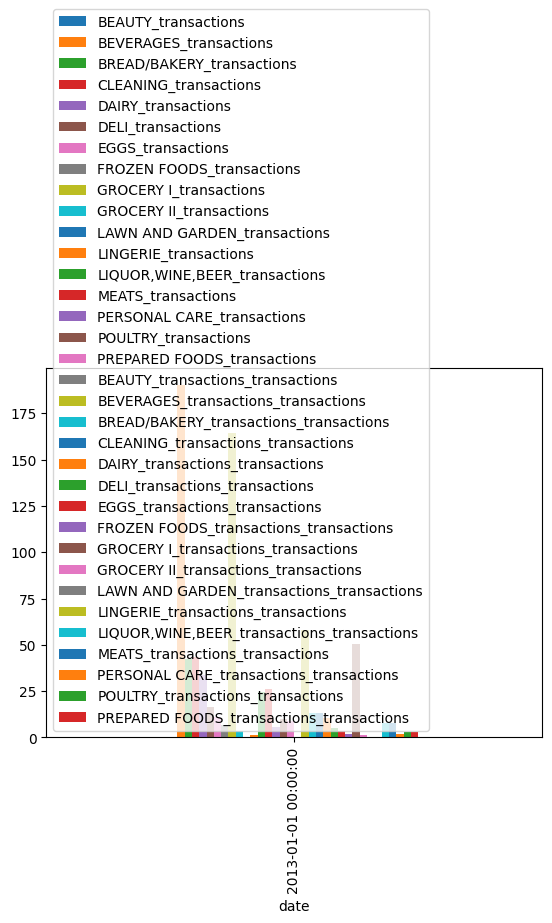

In [168]:
trans_df.plot(kind="bar")

## 2. `future_sales`

Dataset: **test.csv**

* The test data, having the same features as the training data.
* The dates in the test data are for the 15 days after the last date in the training data (`store_sales`)
* Target sales for the dates are to be predicted.


In [42]:
future_sales = pd.read_csv(
    './data/test.csv',
    dtype=dtype,
    parse_dates=['date']
)

In [43]:
future_sales

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


## 3. `store_metadata`

Dataset: **stores.csv**

Store metadata, including

- *city*, 
- *state*, 
- *type*
- *cluster*.

In [10]:
store_metadata = pd.read_csv(
    './data/stores.csv',
    dtype=dtype,
)

# store_metadata.info()

## 4. `transactions`

In [15]:
transactions = pd.read_csv(
    './data/transactions.csv',
    dtype=dtype,
    parse_dates=['date']
)

## 5. `holidays_events` 

Dataset: **holidays_events.csv**

Holidays and Events, with metadata.

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [17]:
holidays_events = pd.read_csv(
    './data/holidays_events.csv',
    dtype=dtype,
    parse_dates=['date']
)

## 6. `daily_oil_price`

Dataset: **oil.csv**

Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.

* Includes daily oil price. 
* Includes values during both the train and test data timeframes. 

In [12]:
daily_oil_price = pd.read_csv(
    './data/oil.csv',
    dtype=dtype,
    parse_dates=['date']
)

# daily_oil_price.info()

# TREND

Let's Examine the Trend in Favorita store sales by answering the following questions.

1. Total store sales strend
2. Product families' sales trend
3. Total transactions trend

In [184]:
# Function for moving average plot
def plot_moving_average(df, plot_df=None, title="N/A", windows=None, axes=None, remove_legend=False, legend_loc=None):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,
                                             ncols=2,
                                             figsize=(30,18))

    if windows is None:
      windows = [7, 30, 92, 365]
    
    if axes is None:
      axes =[ax1, ax2, ax3, ax4]

    if plot_df is None:
          plot_df = df

    for window, ax in zip(windows, axes):
      moving_average = df.rolling(
          window=window,
          center=True,
          min_periods=window//2
      ).mean()

      plot_df.plot(style=".", color="0.5", ax=ax)
      moving_average.plot(
          ax=ax, linewidth=3, title=f"{title} {window}-Day Moving Average", legend=False
      )

      if remove_legend:
        try:
          ax.get_legend().remove()
        except:
          pass

    # Use a single Legend
    if legend_loc:
      handles, labels = axes[-1].get_legend_handles_labels()
      fig.legend(handles, labels, loc=legend_loc);

In [189]:
# 1. Average sales Favorita makes each day
daily_average_sales = store_sales.groupby('date')['sales'].mean()
daily_average_sales

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
                 ...    
2017-08-11    463.733856
2017-08-12    444.798309
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Name: sales, Length: 1684, dtype: float32

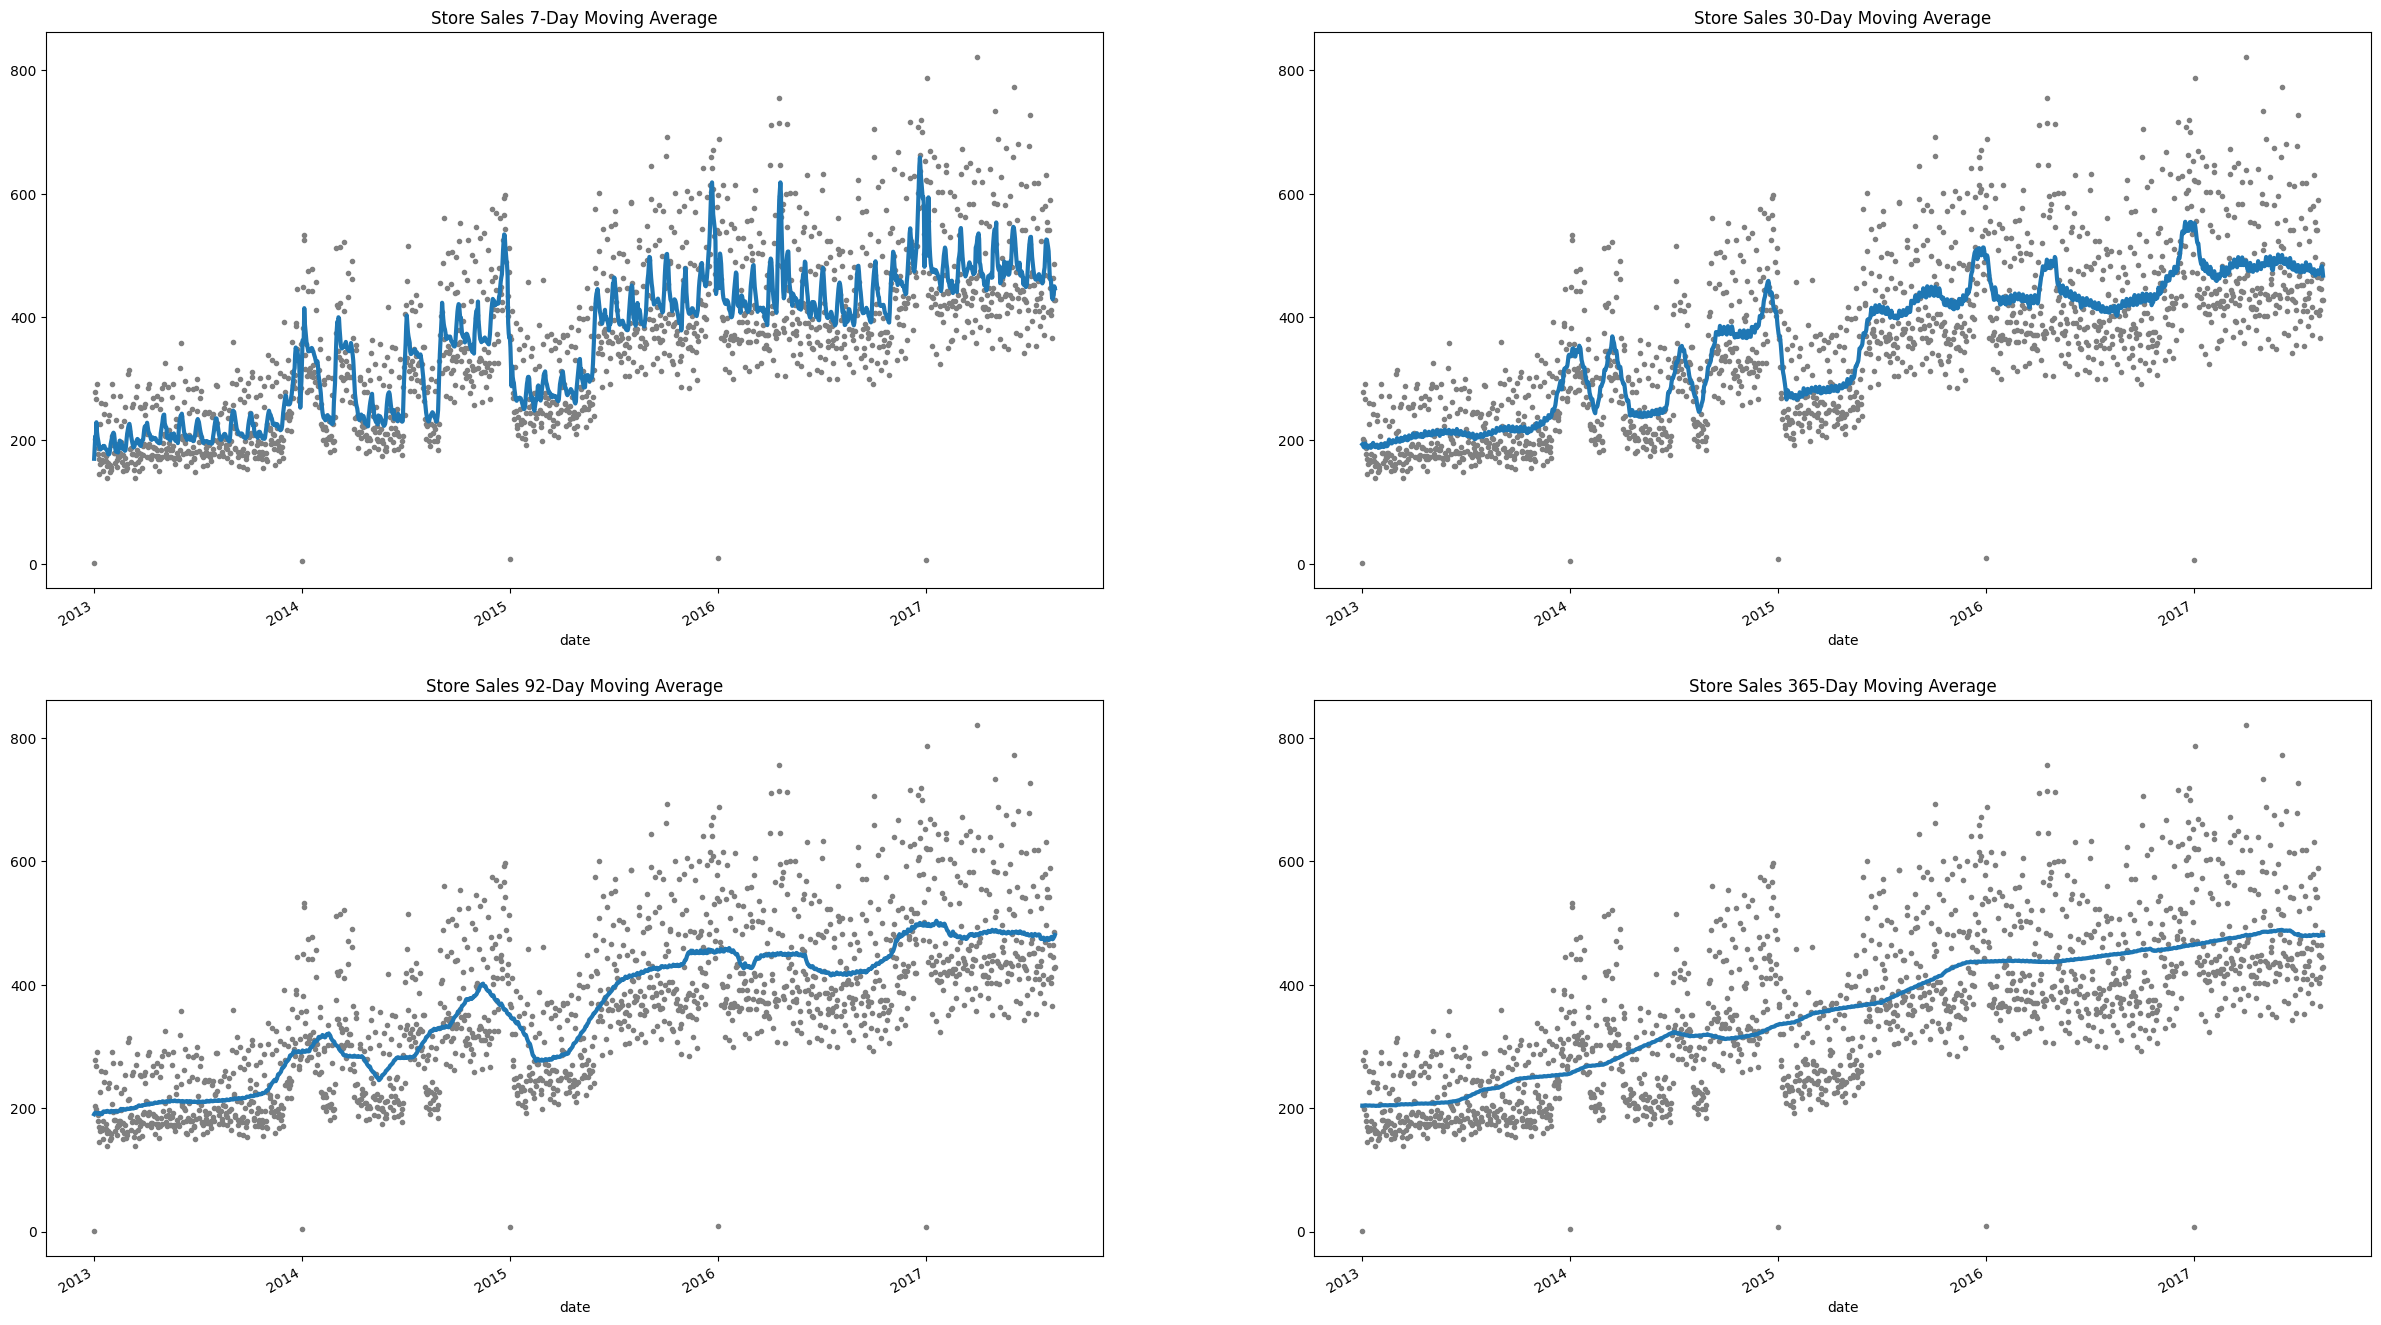

In [190]:
# Let's see the trend
plot_moving_average(df=daily_average_sales, title="Store Sales")

##2. Average sales each product family brings to Favorita each day


Favorita stores has 33 product families.
* What's the sales trend for each product family?

In [209]:
store_sales.groupby(['date', 'store_nbr'])['sales'].mean()

date        store_nbr
2013-01-01  1              0.000000
            10             0.000000
            11             0.000000
            12             0.000000
            13             0.000000
                            ...    
2017-08-15  54           383.844177
            6            419.673004
            7            568.008972
            8            537.087158
            9            564.741699
Name: sales, Length: 90936, dtype: float32

In [210]:
# Group by 'date' and 'family', calculate mean sales
daily_avg_family_sales = store_sales.groupby(['date', 'family'])['sales'].mean().reset_index()

# Pivot the data for easier plotting (date as index, family as columns)
pivot_df = daily_avg_family_sales.pivot(index='date', columns='family', values='sales')
pivot_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.000000,0.0,0.037037,15.000000,0.0,3.344241,0.0,3.444444,2.648148,1.316481,...,0.0,2.051870,0.462963,0.0,0.0,0.789574,0.700870,0.0,0.0,0.000000
2013-01-02,4.722222,0.0,3.833333,1335.036987,0.0,486.042938,0.0,1382.018555,432.981476,291.750000,...,0.0,386.508606,318.592590,0.0,0.0,258.812683,98.853935,0.0,0.0,28.273148
2013-01-03,2.981482,0.0,2.314815,964.907410,0.0,341.786682,0.0,1035.055542,333.351837,206.897324,...,0.0,307.359222,232.740738,0.0,0.0,197.673965,66.507187,0.0,0.0,20.265018
2013-01-04,3.129630,0.0,2.462963,1003.092590,0.0,309.666077,0.0,964.148132,336.074066,187.837204,...,0.0,400.480804,209.314819,0.0,0.0,199.491013,82.832703,0.0,0.0,23.946684
2013-01-05,6.333333,0.0,3.537037,1441.074097,0.0,414.217804,0.0,1298.666626,427.444458,254.350845,...,0.0,386.649841,311.462952,0.0,0.0,249.537201,107.964317,0.0,0.0,23.067350


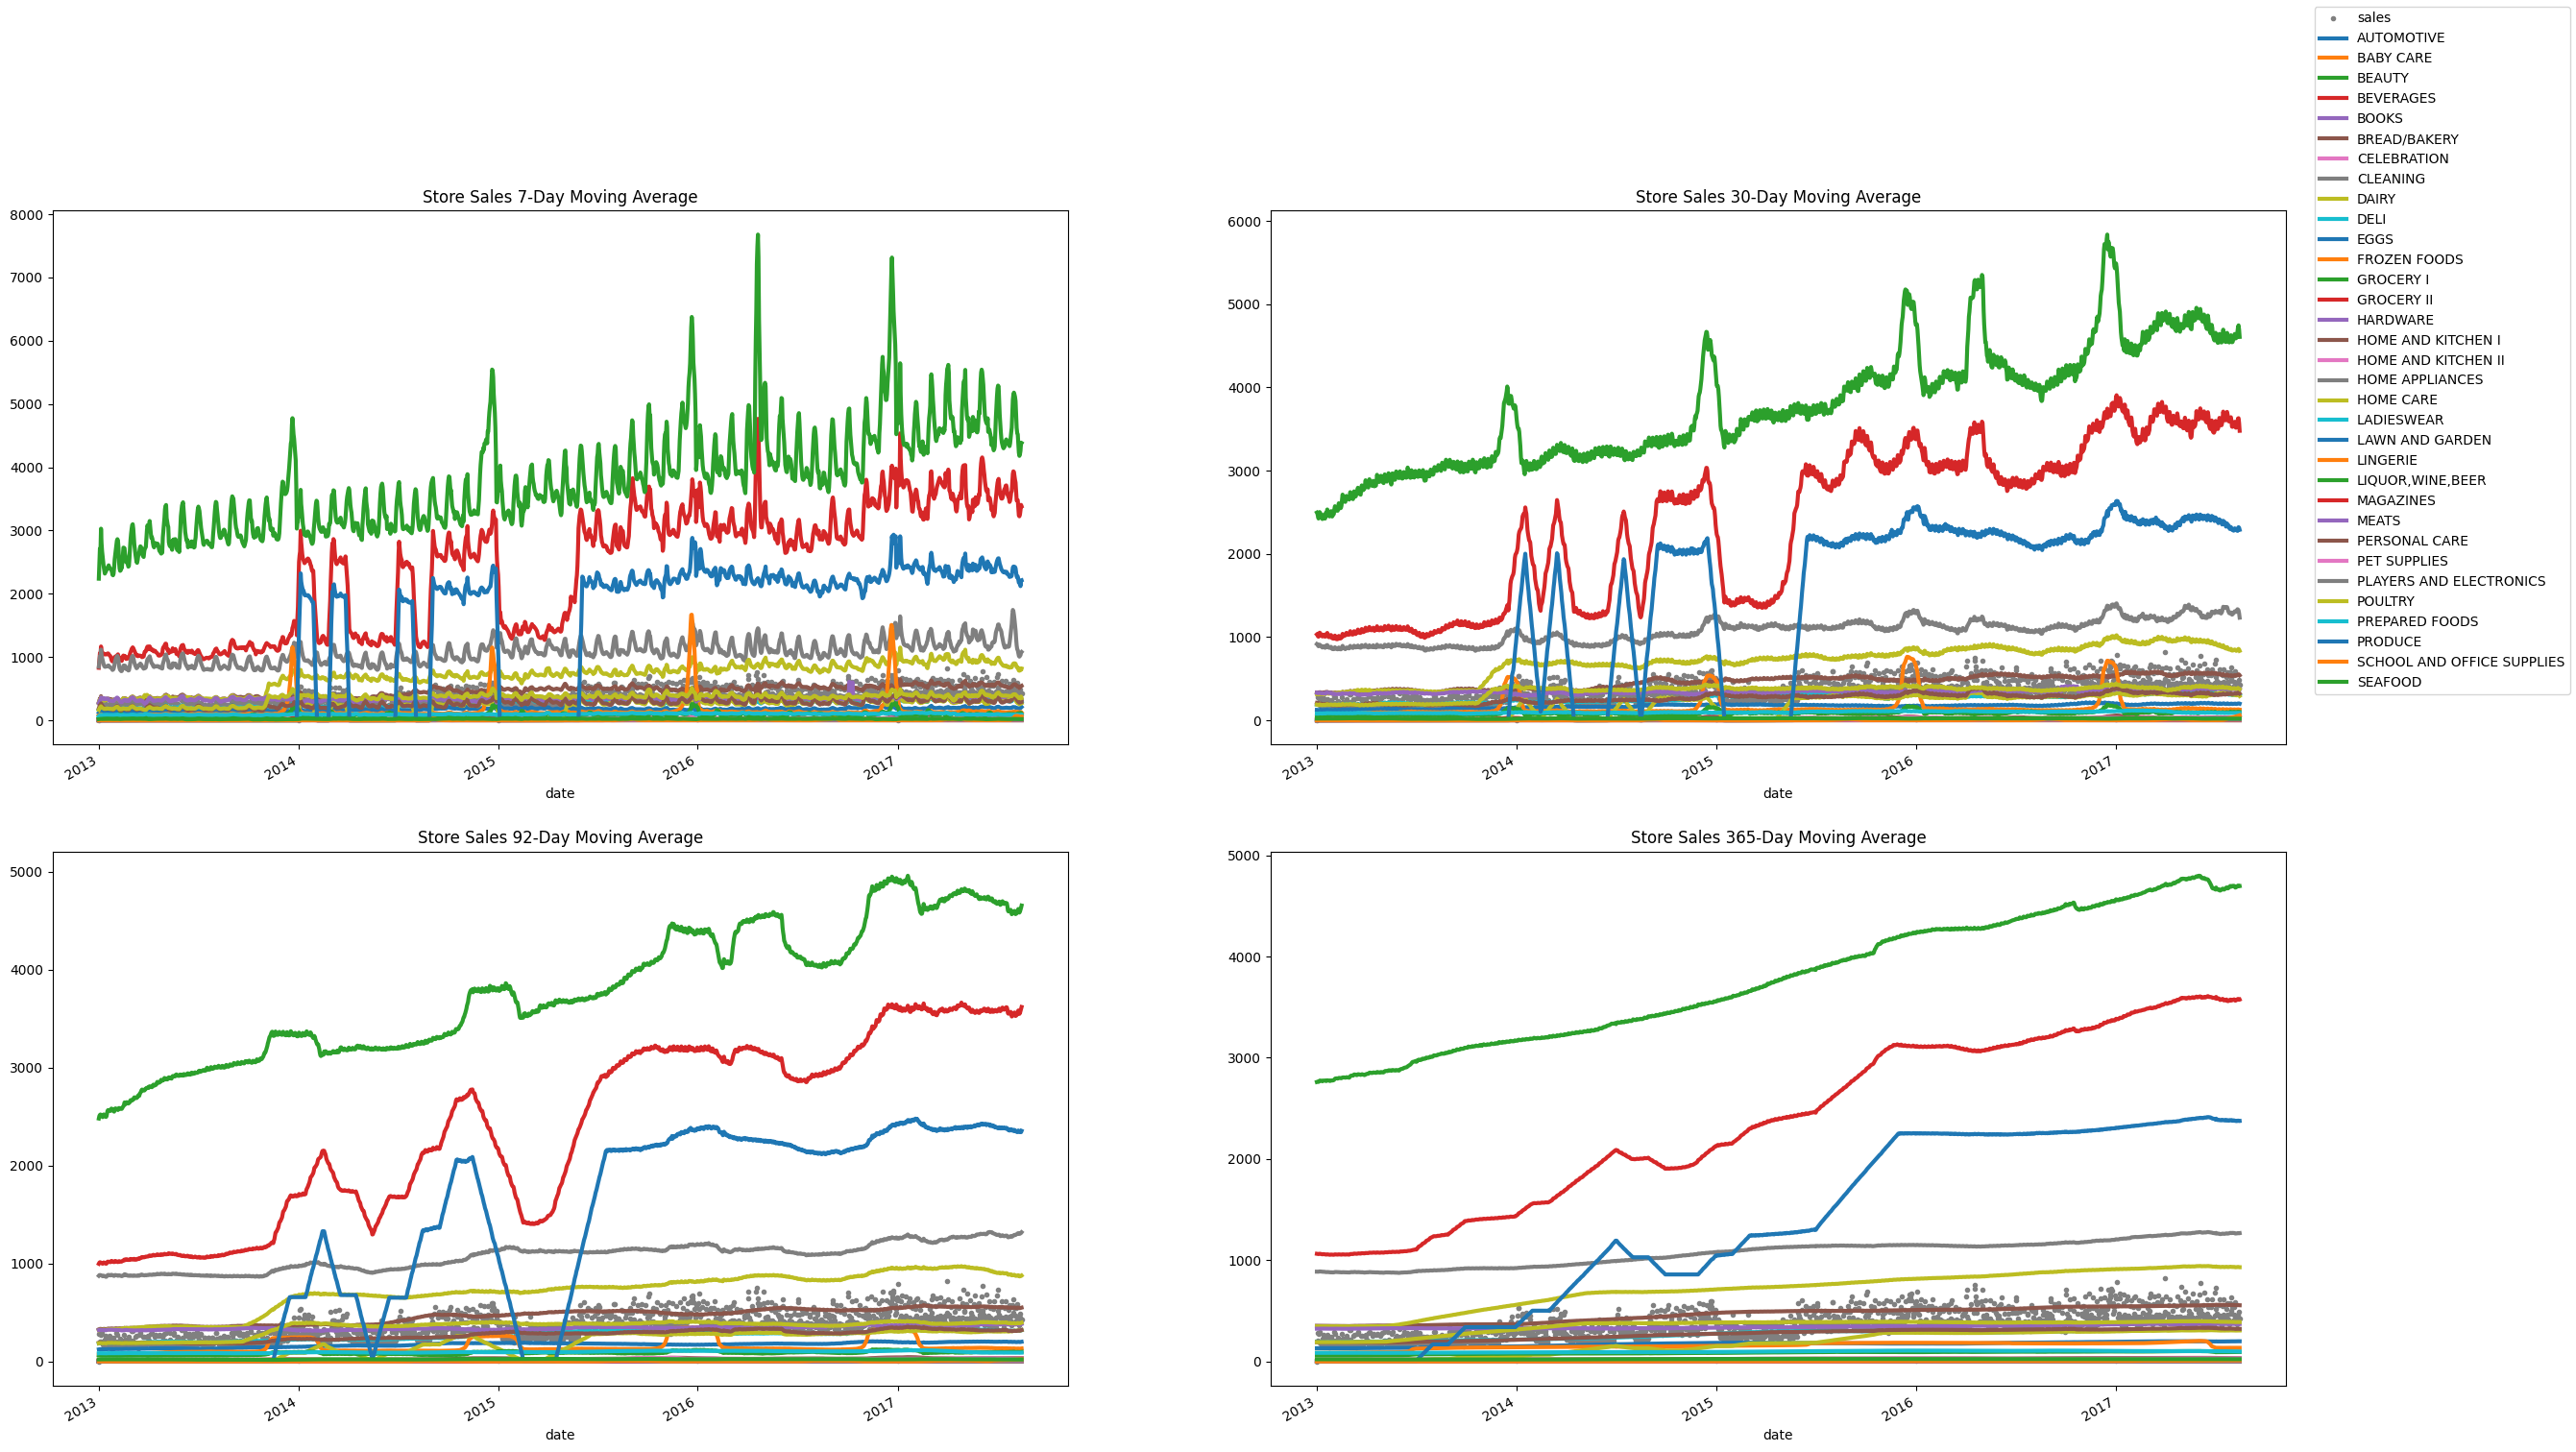

In [211]:
plot_moving_average(df=pivot_df, plot_df=daily_average_sales, title="Store Sales", legend_loc="upper right")

In [212]:
transactions

NameError: name 'transactions' is not defined

In [213]:
plot_moving_average(
    df=transactions.groupby('date')['transactions'].mean(),
    title="transactions",
    )

NameError: name 'transactions' is not defined

### Product families with highest sales values.

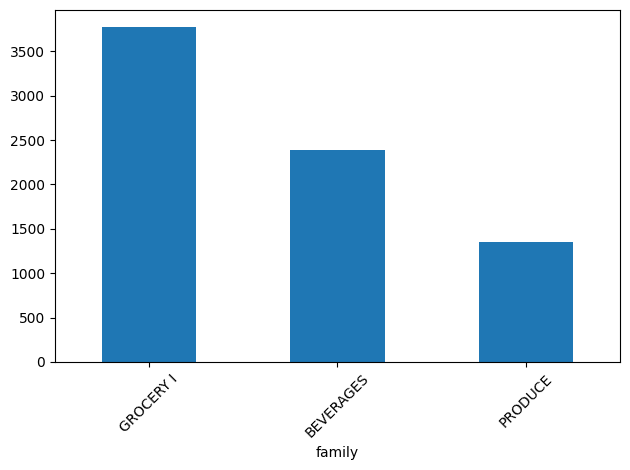

In [140]:
# Group by product 'family' and calculate the average sales
avg_sales = store_sales.groupby('family')['sales'].mean().sort_values(ascending=False)

# Take the top n product families
n = 3
top_families = avg_sales.head(n)

#  Plottinh
top_families.plot(kind="bar")
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures all labels fit within the figure area
plt.show()

View the Top families sales trend

In [141]:
pivot_df_filtered = pivot_df[top_families.index]

# Calculate daily average sales for the top families
daily_avg_sales_top_families = pivot_df_filtered.mean(axis=1)
daily_avg_sales_top_families

date
2013-01-01       9.320988
2013-01-02    1692.049316
2013-01-03    1215.944458
2013-01-04    1172.351807
2013-01-05    1643.049316
                 ...     
2017-08-11    3370.809326
2017-08-12    3288.481445
2017-08-13    3621.729736
2017-08-14    3181.760986
2017-08-15    3210.432617
Length: 1684, dtype: float32

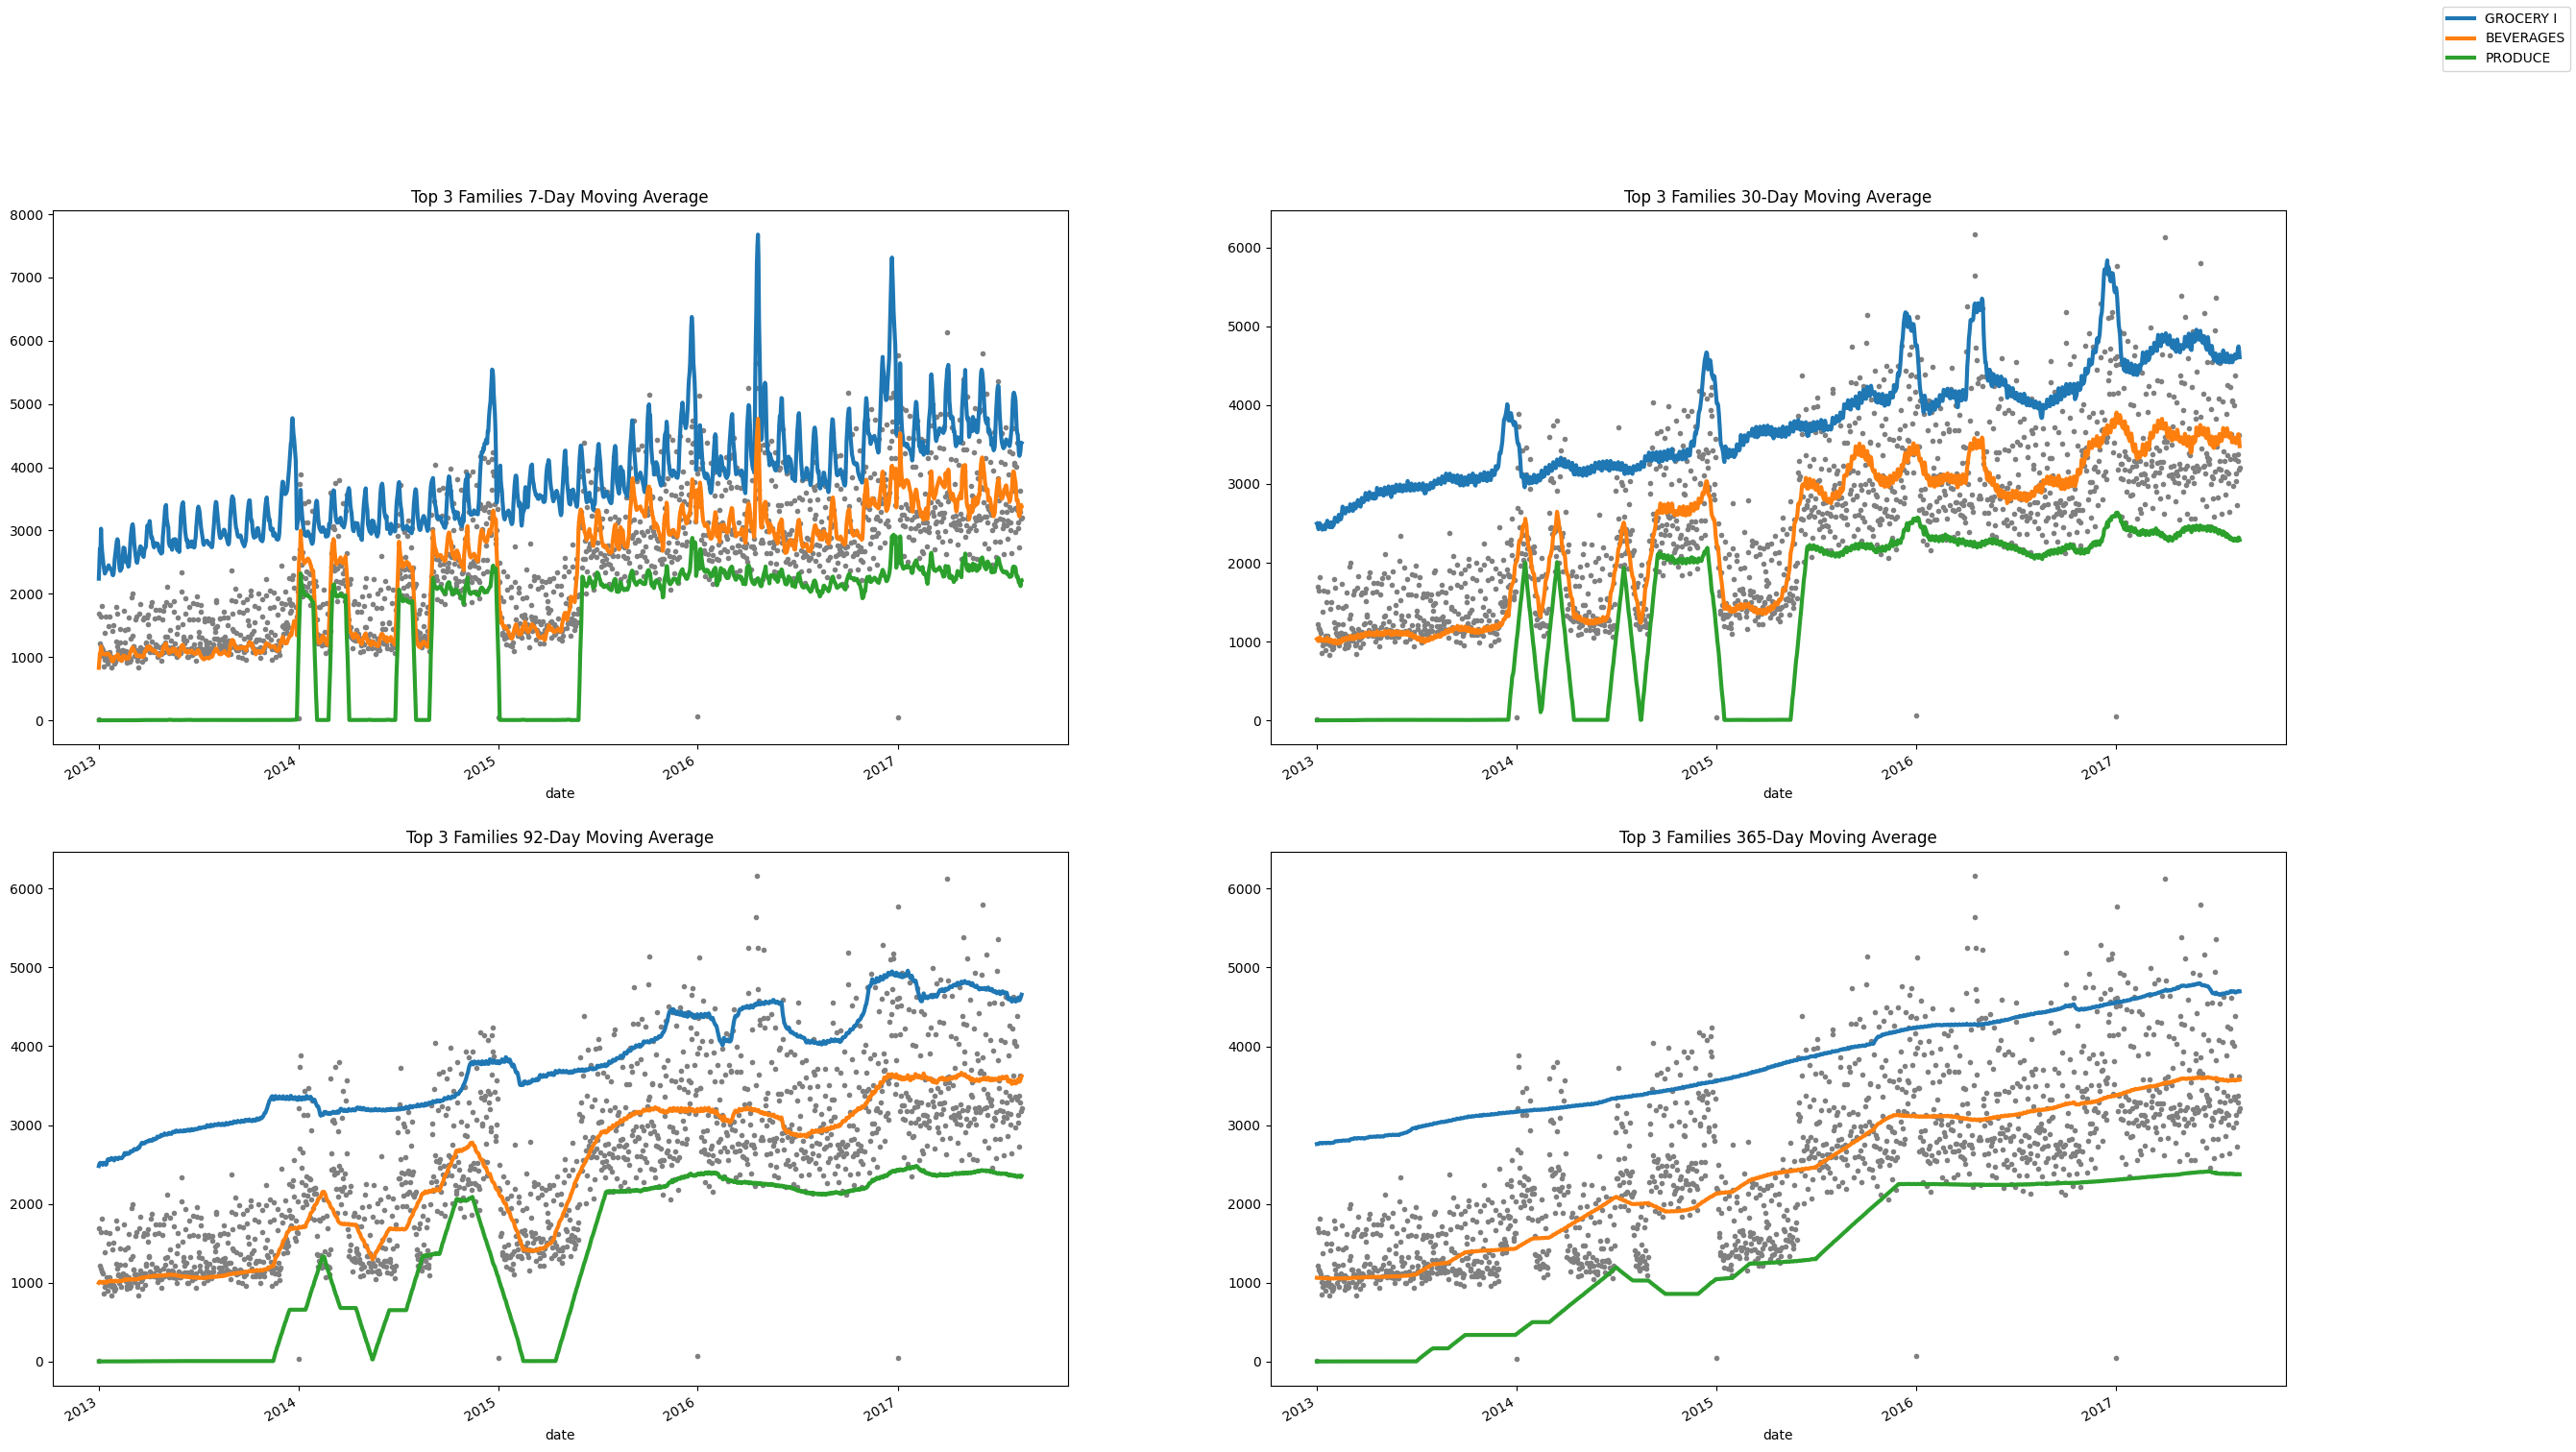

In [142]:
plot_moving_average(
    pivot_df_filtered, 
    title=f"Top {n} Families",
    plot_df= daily_avg_sales_top_families, legend_loc="upper right")

how many stores? how many product groups?
coverage in terms of start/end of record per store
summary of sales by store, do statistical summaries on the summaries. E.g., average sales in a year, variation, etc.
there are marked "jumps" in the mean aggregate over stores. What explains these? Could be artefact start/end
similar analysis for product groups
interaction analysis product groups and stores. Which stores sell which products? How does the product compositiòn distribute?